In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('/home/hrai/codes/hpe_library/')
from lib_import import *
from my_utils import *

# 주요 디렉토리 경로
user = getpass.getuser()
motionbert_root = '/home/{}/codes/MotionBERT'.format(user)
os.chdir(motionbert_root + '/custom_codes/GPA')

In [4]:
def normalize_2d_pose(joint_2d, W=1000, H=1000):
    joint_2d_norm = joint_2d.copy()
    joint_2d_norm = joint_2d_norm / W * 2 - [1, H / W]
    return joint_2d_norm

def normalize_3d_pose(joint_3d, W=1000, H=1000, already_centered=False):
    joint_3d_norm = joint_3d.copy()
    if not already_centered:
        joint_3d_norm[:, :2] = joint_3d_norm[:, :2] / W * 2 - [1, H / W]
        joint_3d_norm[:, 2:] = joint_3d_norm[:, 2:] / W * 2
    else:
        joint_3d_norm = joint_3d_norm / W * 2
        
    return joint_3d_norm

# move to canonical space
def convert_to_canonical_space(pose, center=None, cam_proj=None, rotate_to_camera_space=True, fixed_scale=False):
    pose -= pose[0, :]
    if center is not None:
        pose += center
    if rotate_to_camera_space:
        rot_x_90 = Rotation.from_rotvec([np.pi/2, 0, 0]).as_matrix()
        pose = rotate_torso_by_R(pose, rot_x_90)
        rot_y_180 = Rotation.from_rotvec([0, np.pi, 0]).as_matrix()
        pose = rotate_torso_by_R(pose, rot_y_180)
    # if fixed_scale:
    #     pose_projected = projection(pose, cam_proj)
    #     bbox_proj = get_bbox_from_pose2d(pose_projected)
    #     bbox_h_proj = bbox_proj[3] - bbox_proj[1] # delta y_proj
    #     bbox_w_proj = bbox_proj[2] - bbox_proj[0] # delta x_proj
    #     print(f'bbox_h_proj: {bbox_h_proj}, bbox_w_proj: {bbox_w_proj}')

    #     bbox_h_tar = 500
    #     bbox_w_tar = bbox_h_tar * bbox_w_proj / bbox_h_proj
    #     print(f'bbox_h_tar: {bbox_h_tar}, bbox_w_tar: {bbox_w_tar}')

    #     ratio = bbox_h_tar / bbox_h_proj
    #     print(f'ratio: {ratio:.4f}')

    #     Z_src = start_pose[0, 0]
    #     Z_tar = Z_src / ratio
    #     print(f'Z_src: {Z_src:.4f}, Z_tar: {Z_tar:.4f}')

    #     aligned_pose = start_pose.copy() + np.array([Z_tar - Z_src, 0, 0])
    return pose

def summarize_number_list(number_list):
    if not number_list:
        return ""

    # Initialize variables
    summarized_list = []
    start = number_list[0]
    end = number_list[0]

    for number in number_list[1:] + [None]:
        if number == end + 1:
            # Continue the sequence
            end = number
        else:
            # End of a sequence
            if start == end:
                # Single number
                summarized_list.append(str(start))
            else:
                # Range of numbers
                summarized_list.append(f"{start}-{end}")
            start = number
            end = number

    #return ', '.join(summarized_list)
    return summarized_list

### Load H36M

In [5]:
h36m_3d_world, h36m_cam_param = load_h36m()

==> Loading 3D data wrt World CS...


In [6]:
# ---------------------------------------------- Get sample data from h36m
subject = 'S1'
action = 'Walking'
pose3d_s1_walking, cam_param_s1_walking = get_pose_seq_and_cam_param(h36m_3d_world, h36m_cam_param, subject, action)

# ---------------------------------------------- Get 54138969 camera parameters
W, H = cam_param_s1_walking['54138969']['W'], cam_param_s1_walking['54138969']['H']
cam_54138969_ext = cam_param_s1_walking['54138969']['ext']
cam_54138969_int = cam_param_s1_walking['54138969']['int']
cam_54138969_proj = cam_param_s1_walking['54138969']['proj']
cam_54138969_origin = cam_param_s1_walking['54138969']['C']
cam_54138969_origin_z = cam_param_s1_walking['54138969']['C'][2][0]

# ---------------------------------------------- Generate virtual camera 
dfx, dfy, dcx, dcy = 0, 0, 0, 0
calib_mat = np.array(cam_54138969_int['calibration_matrix']) + np.array([[dfx, 0, dcx], [0, dfy, dcy], [0, 0, 0]])

# ---------------------------------------------- generate cameras    
roll_angle = 0
pitch_angle = 0
yaw_angle = 0 

# camera 1                                        
h = -3.0 #cam_54138969_origin_z
cam_origin = np.array([0, 0, h])
forward = [0, 0, 1]
left = [1, 0, 0]
up = np.cross(forward, left)
cam_default_R = np.array([left, up, forward]) # default camera orientation
camera = Camera(origin=cam_origin, 
                calib_mat=calib_mat, 
                cam_default_R=cam_default_R, 
                roll=roll_angle,
                pitch=pitch_angle,
                yaw=yaw_angle,
                IMAGE_HEIGHT=H, 
                IMAGE_WIDTH=W, 
                cam_name='camera1')

# camera 2
h = -3.0 #cam_54138969_origin_z
cam_origin = np.array([0, 0, h])
forward = [0, 0, 1]
left = [-1, 0, 0]
up = np.cross(forward, left)
cam_default_R = np.array([left, up, forward]) # default camera orientation
camera2 = Camera(origin=cam_origin, 
                calib_mat=calib_mat, 
                cam_default_R=cam_default_R, 
                roll=roll_angle,
                pitch=pitch_angle,
                yaw=yaw_angle,
                IMAGE_HEIGHT=H, 
                IMAGE_WIDTH=W, 
                cam_name='camera1')

# ---------------------------------------------- Reference pose
frame_num = 0
ref_pose = pose3d_s1_walking[frame_num].copy()
ref_pose = convert_to_canonical_space(ref_pose, cam_proj=camera.cam_proj)
start_pose = ref_pose.copy() 
# ---------------------------------------------- World frame
world_frame = generate_world_frame()

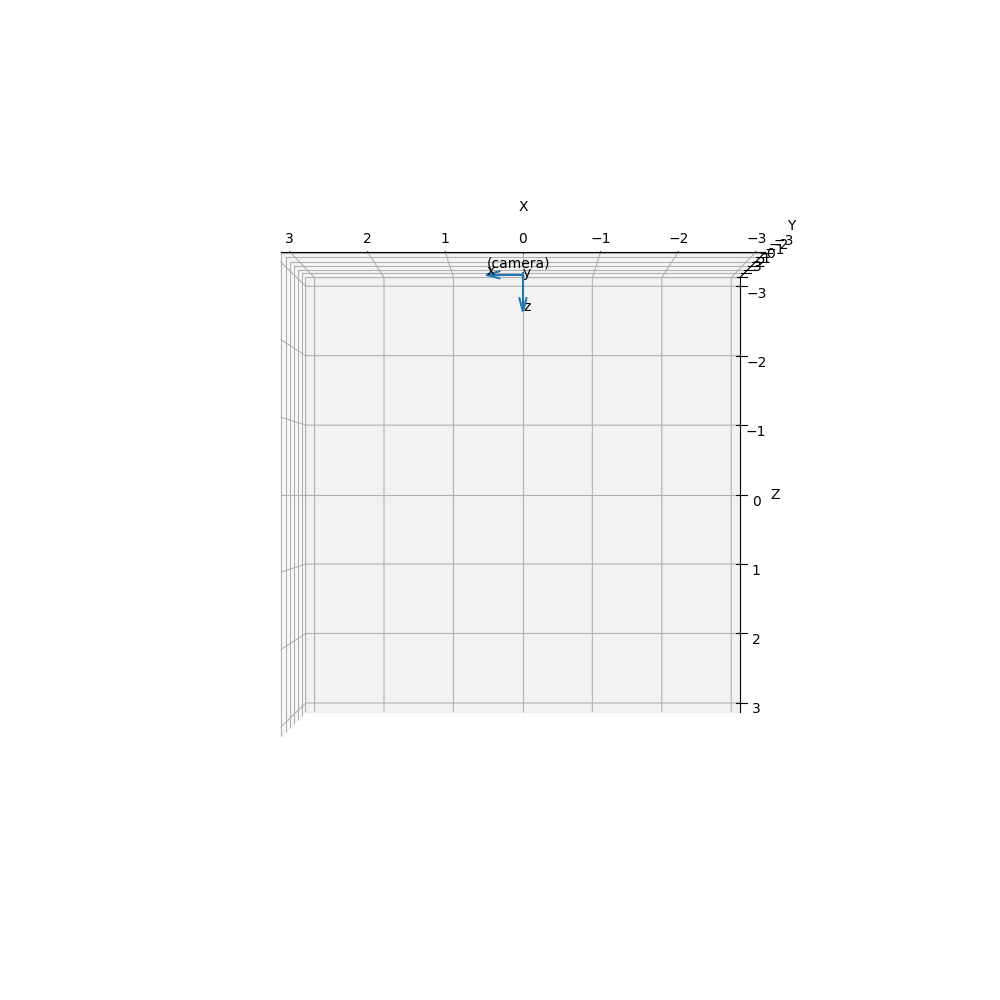

In [7]:
%matplotlib widget
fig = plt.figure(5, figsize=(10, 10))
fig.clear()
ax = axes_3d(fig, xlim=(-3, 3), ylim=(-3,3), zlim=(-3,3), view=(180, 90))
camera.cam_frame.draw3d()
plt.show()

### One Pose Example

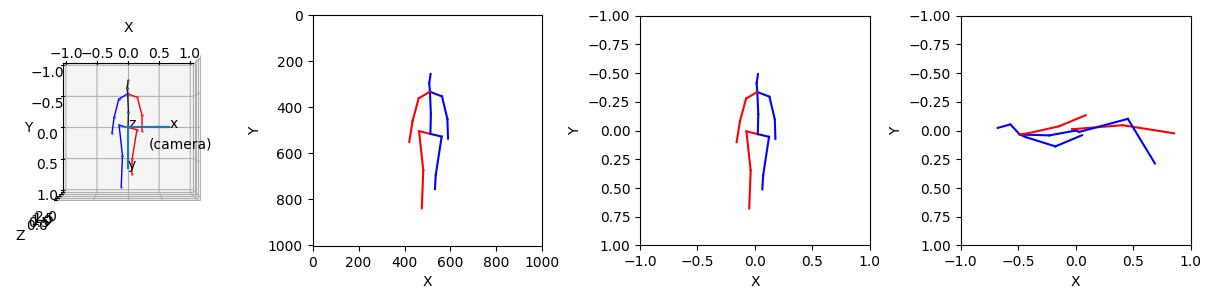

In [115]:
frame_num = 1000
src_pose = pose3d_s1_walking[frame_num]
src_pose_canonical = convert_to_canonical_space(src_pose, cam_proj=camera.cam_proj)
src_pose_canonical_proj = projection(src_pose_canonical, camera.cam_proj)
src_pose_canonical_proj_norm = normalize_3d_pose(src_pose_canonical_proj.copy()) # (src_pose_proj.copy() - W/2) * 2 / W

%matplotlib inline
fig = plt.figure(0, layout='constrained', figsize=(12, 8))
fig.clear()

ax_3d = axes_3d(fig, loc=141, xlim=(-1,1), ylim=(-1,1), zlim=(0,2), view=(-90, -90))
ax_2d = axes_2d(fig, loc=142, W=W, H=H)
ax_2d_norm = axes_2d(fig, loc=143, normalize=True)
ax_2d_norm2 = axes_2d(fig, loc=144, normalize=True)

# 3d plot
fig.sca(ax_3d)
draw_3d_pose(ax_3d, src_pose_canonical)
camera.cam_frame.draw3d()
# 2d plot
draw_2d_pose(ax_2d, src_pose_canonical_proj)
# 2d plot normalized
draw_2d_pose(ax_2d_norm, src_pose_canonical_proj_norm, normalize=True)
draw_2d_pose(ax_2d_norm2, src_pose_canonical[:, [1, 2]], normalize=True)

plt.show()

In [6]:
pose3d_list = pose3d_s1_walking[:1000].copy()
pose3d_list -= pose3d_list[:, 0:1, :]


def batch_projection_for_nparray(batch_pose_3d, cam_proj):
    batch_pose_3d = torch.from_numpy(batch_pose_3d).float()
    if len(batch_pose_3d.shape) == 3:
        batch_cam_proj = torch.from_numpy(cam_proj).float().unsqueeze(0).repeat(batch_pose_3d.shape[0], 1, 1)
    elif len(batch_pose_3d.shape) == 4:             
        batch_cam_proj = torch.from_numpy(cam_proj).float().unsqueeze(0).unsqueeze(0).repeat(batch_pose_3d.shape[0], batch_pose_3d.shape[1], 1, 1)
    else:
        raise ValueError('batch_pose_3d.shape should be (N, 17, 3) or (N, F, 17, 3)')        
    print(batch_pose_3d.shape, batch_cam_proj.shape)                                               
    batch_pose_2d = batch_projection(batch_pose_3d, batch_cam_proj)
    return batch_pose_2d.detach().cpu().numpy()

pose2d_list = batch_projection_for_nparray(pose3d_list, camera.cam_proj)       


torch.Size([1000, 17, 3]) torch.Size([1000, 3, 4])


In [7]:
pose2d_list.shape

(1000, 17, 3)

100%|██████████| 100/100 [00:06<00:00, 15.00it/s]


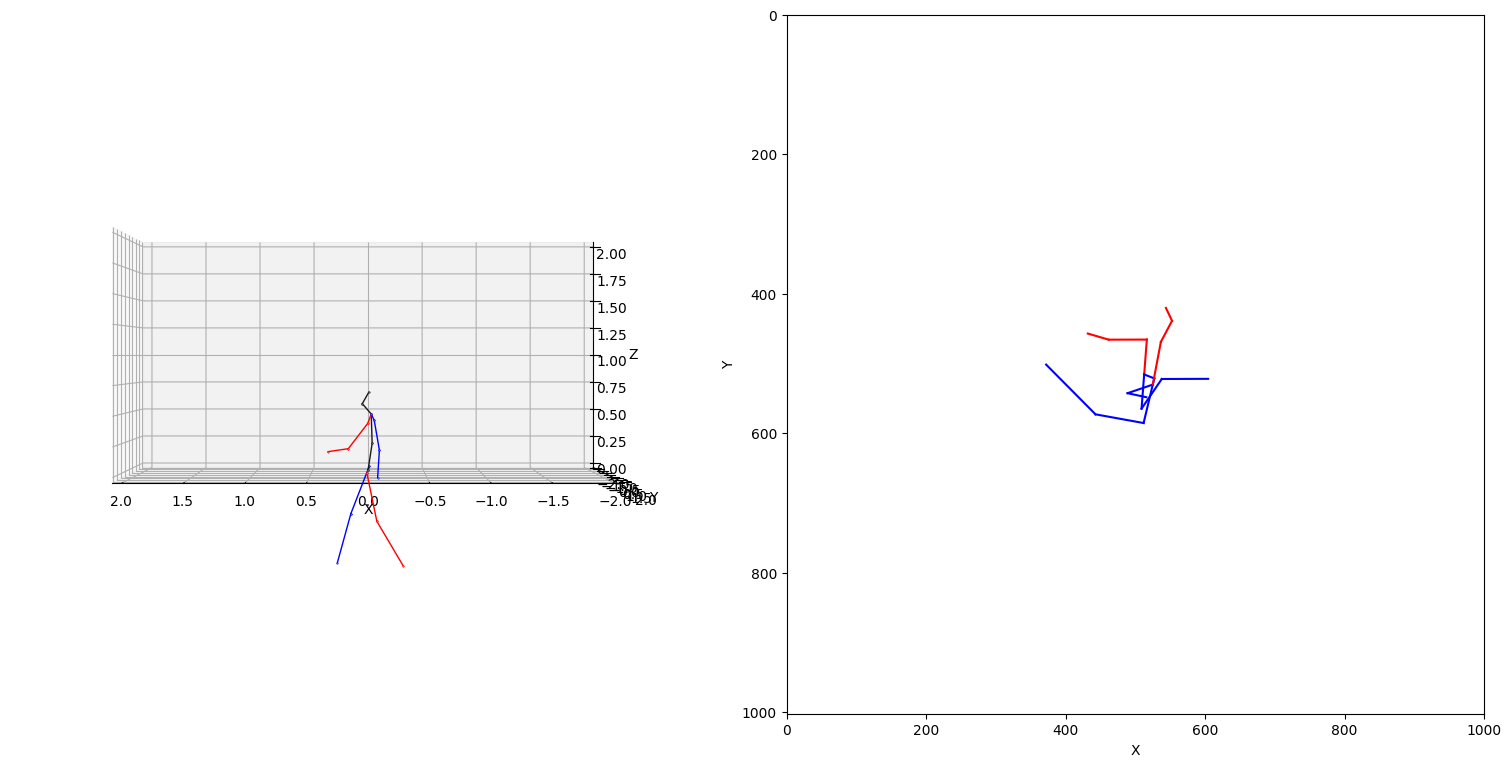

In [17]:
fig = plt.figure(figsize=(15, 10), layout="constrained")
axd = fig.subplot_mosaic(
    """
    AB
    """,
    per_subplot_kw={('A'): {'projection': '3d'}}
)

ax_3d = axes_3d(ax=axd['A'], zlim=(0,2), view=(0, 90))
ax_2d = axes_2d(ax=axd['B'], W=W, H=H)

pose_canonical = pose3d_list[0]
pose_projected = pose2d_list[0]
img = get_2d_pose_image(pose_projected, W=W, H=H)

videowriter = imageio.get_writer('h36m_s1_walking_canonical.mp4', fps=30)
for i in tqdm(range(100)):
    clear_axes(ax_3d)
    clear_axes(ax_2d)

    pose_canonical = pose3d_list[i]
    pose_projected = pose2d_list[i]

    draw_3d_pose(ax_3d, pose_canonical)
    draw_2d_pose(ax_2d, pose_projected, W=W, H=H)
    
    canvas = FigureCanvas(fig)
    canvas.draw()
    image_from_plot = np.array(canvas.renderer._renderer)
    image_from_plot = cv2.cvtColor(image_from_plot, cv2.COLOR_RGB2BGR)

    videowriter.append_data(image_from_plot)
videowriter.close()

### Global Pose Alignment

In [15]:
bbox_proj = get_bbox_from_pose2d(pose_projected)
bbox_h_proj = bbox_proj[3] - bbox_proj[1] # delta y_proj
bbox_w_proj = bbox_proj[2] - bbox_proj[0] # delta x_proj
print(f'bbox_h_proj: {bbox_h_proj}, bbox_w_proj: {bbox_w_proj}')

bbox_h_tar = 250
bbox_w_tar = bbox_h_tar * bbox_w_proj / bbox_h_proj
print(f'bbox_h_tar: {bbox_h_tar}, bbox_w_tar: {bbox_w_tar}')

fx = camera.intrinsic[0, 0]
fy = camera.intrinsic[1, 1]
cx, cy = camera.intrinsic[0, 2], camera.intrinsic[1, 2]
print(f'fx: {fx:.4f}, fy: {fy:.4f}, cx: {cx:.4f}, cy: {cy:.4f}')

delta_X_src = np.max(start_pose[:, 1]) - np.min(start_pose[:, 1])
delta_Y_src = np.max(start_pose[:, 2]) - np.min(start_pose[:, 2])
print(f'delta_X_src: {delta_X_src:.4f}, delta_Y_src: {delta_Y_src:.4f}')
 

Z_r = (fx*delta_X_src + fy*delta_Y_src) / (bbox_h_tar + bbox_w_tar)
print(f'Z_r: {Z_r:.4f}')

x_r_tar, y_r_tar = 0, 0

X_r_hat = Z_r*(x_r_tar - cx) / fx
Y_r_hat = Z_r*(y_r_tar - cy) / fy
print(f'X_r_hat: {X_r_hat:.4f}, Y_r_hat: {Y_r_hat:.4f}')

J_r_hat = np.array([Z_r, -X_r_hat, Y_r_hat]) # np.array([X_r_hat, Y_r_hat, Z_r])
print(f'J_r_hat: {J_r_hat}')

# gpa
aligned_pose = start_pose - J_r_hat
aligned_pose_proj = projection(aligned_pose, camera.cam_proj)
bbox_aligned = get_bbox_from_pose2d(aligned_pose_proj)
bbox_h_aligned = bbox_aligned[3] - bbox_aligned[1] 
bbox_w_aligned = bbox_aligned[2] - bbox_aligned[0] 
print(f'root_aligned: {aligned_pose_proj[0, :2]}')
print(f'bbox_h_aligned: {bbox_h_aligned}, bbox_w_aligned: {bbox_w_aligned}')

# visualize

src_pose = aligned_pose.copy()

%matplotlib widget
fig = plt.figure(1)
fig.clear()
ax_3d = axes_3d(fig, loc=121, xlim=(0,4), zlim=(0,2))
ax_2d = axes_2d(fig, loc=122, W=W, H=H)
fig.sca(ax_3d)
draw_3d_pose(ax_3d, src_pose)
camera.cam_frame.draw3d()
img = get_2d_pose_image(aligned_pose_proj, W=W, H=H)
ax_2d.imshow(img)
ax_2d.plot(bbox_aligned[0], bbox_aligned[1], 'rx')
ax_2d.plot(bbox_aligned[2], bbox_aligned[3], 'rx')
plt.show()

NameError: name 'pose_projected' is not defined

In [ ]:
bbox_proj = get_bbox_from_pose2d(pose_projected)
bbox_h_proj = bbox_proj[3] - bbox_proj[1] # delta y_proj
bbox_w_proj = bbox_proj[2] - bbox_proj[0] # delta x_proj
print(f'bbox_h_proj: {bbox_h_proj}, bbox_w_proj: {bbox_w_proj}')

bbox_h_tar = 500
bbox_w_tar = bbox_h_tar * bbox_w_proj / bbox_h_proj
print(f'bbox_h_tar: {bbox_h_tar}, bbox_w_tar: {bbox_w_tar}')

ratio = bbox_h_tar / bbox_h_proj
print(f'ratio: {ratio:.4f}')

Z_src = start_pose[0, 0]
Z_tar = Z_src / ratio
print(f'Z_src: {Z_src:.4f}, Z_tar: {Z_tar:.4f}')

aligned_pose = start_pose.copy() + np.array([Z_tar - Z_src, 0, 0])
aligned_pose_proj = projection(aligned_pose, camera.cam_proj)
bbox_aligned = get_bbox_from_pose2d(aligned_pose_proj)
bbox_h_aligned = bbox_aligned[3] - bbox_aligned[1]
bbox_w_aligned = bbox_aligned[2] - bbox_aligned[0]
bbox_cx = (bbox_aligned[0] + bbox_aligned[2]) / 2
bbox_cy = (bbox_aligned[1] + bbox_aligned[3]) / 2
print(f'bbox_h_aligned: {bbox_h_aligned}, bbox_w_aligned: {bbox_w_aligned}')
print(f'bbox_cx: {bbox_cx}, bbox_cy: {bbox_cy}')
print(f'root_aligned: {aligned_pose_proj[0, :2]}')

bbox_h_proj: 570, bbox_w_proj: 201
bbox_h_tar: 500, bbox_w_tar: 176.31578947368422
ratio: 0.8772
Z_src: 0.0000, Z_tar: 0.0000
bbox_h_aligned: 570, bbox_w_aligned: 201
bbox_cx: 513.5, bbox_cy: 557.0
root_aligned: [512.54150496 515.45148698]


NameError: name 'aligned_pose' is not defined

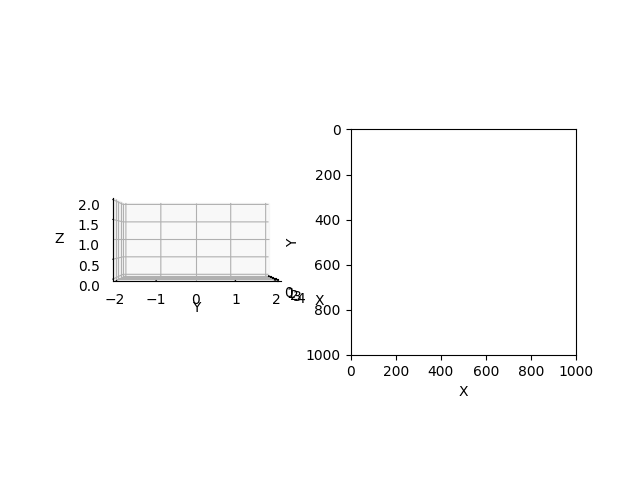

In [16]:
%matplotlib widget
fig = plt.figure(2)
fig.clear()
ax_3d = axes_3d(fig, loc=121, xlim=(0,4), zlim=(0,2))
ax_2d = axes_2d(fig, loc=122, W=W, H=H)
plt.sca(ax_3d)
draw_3d_pose(ax_3d, aligned_pose)
camera.cam_frame.draw3d()
img = get_2d_pose_image(aligned_pose_proj, W=W, H=H)
ax_2d.imshow(img)
ax_2d.plot(bbox_aligned[0], bbox_aligned[1], 'rx')
ax_2d.plot(bbox_aligned[2], bbox_aligned[3], 'rx')
plt.show()

### Load H36M

In [9]:
h36m_pkl = readpkl('/home/hrai/codes/MotionBERT/data/motion3d/h36m_sh_conf_cam_source_final.pkl')
h36m_pkl.keys()

dict_keys(['train', 'test'])

In [19]:
h36m_pkl['train'].keys(), h36m_pkl['test'].keys()

(dict_keys(['joint_2d', 'confidence', 'joint3d_image', 'camera_name', 'source']),
 dict_keys(['joint_2d', 'confidence', 'joint3d_image', 'joints_2.5d_image', '2.5d_factor', 'camera_name', 'action', 'source']))

In [20]:
for key in h36m_pkl['train'].keys():
    print(key, type(h36m_pkl['train'][key]), np.array(h36m_pkl['train'][key]).shape)
print()

for key in h36m_pkl['test'].keys():
    print(key, type(h36m_pkl['test'][key]), np.array(h36m_pkl['test'][key]).shape)

joint_2d <class 'numpy.ndarray'> (1559752, 17, 2)
confidence <class 'numpy.ndarray'> (1559752, 17, 1)
joint3d_image <class 'numpy.ndarray'> (1559752, 17, 3)
camera_name <class 'numpy.ndarray'> (1559752,)
source <class 'list'> (1559752,)

joint_2d <class 'numpy.ndarray'> (566920, 17, 2)
confidence <class 'numpy.ndarray'> (566920, 17, 1)
joint3d_image <class 'numpy.ndarray'> (566920, 17, 3)
joints_2.5d_image <class 'numpy.ndarray'> (566920, 17, 3)
2.5d_factor <class 'numpy.ndarray'> (566920,)
camera_name <class 'numpy.ndarray'> (566920,)
action <class 'list'> (566920,)
source <class 'list'> (566920,)


In [22]:
joint_25d_img, joint_3d_img*factor

NameError: name 'joint_25d_img' is not defined

In [11]:
pwd

'/home/hrai/codes/hpe_library'

54138969 s_09_act_06_subact_01_ca_04
['119483-123303']


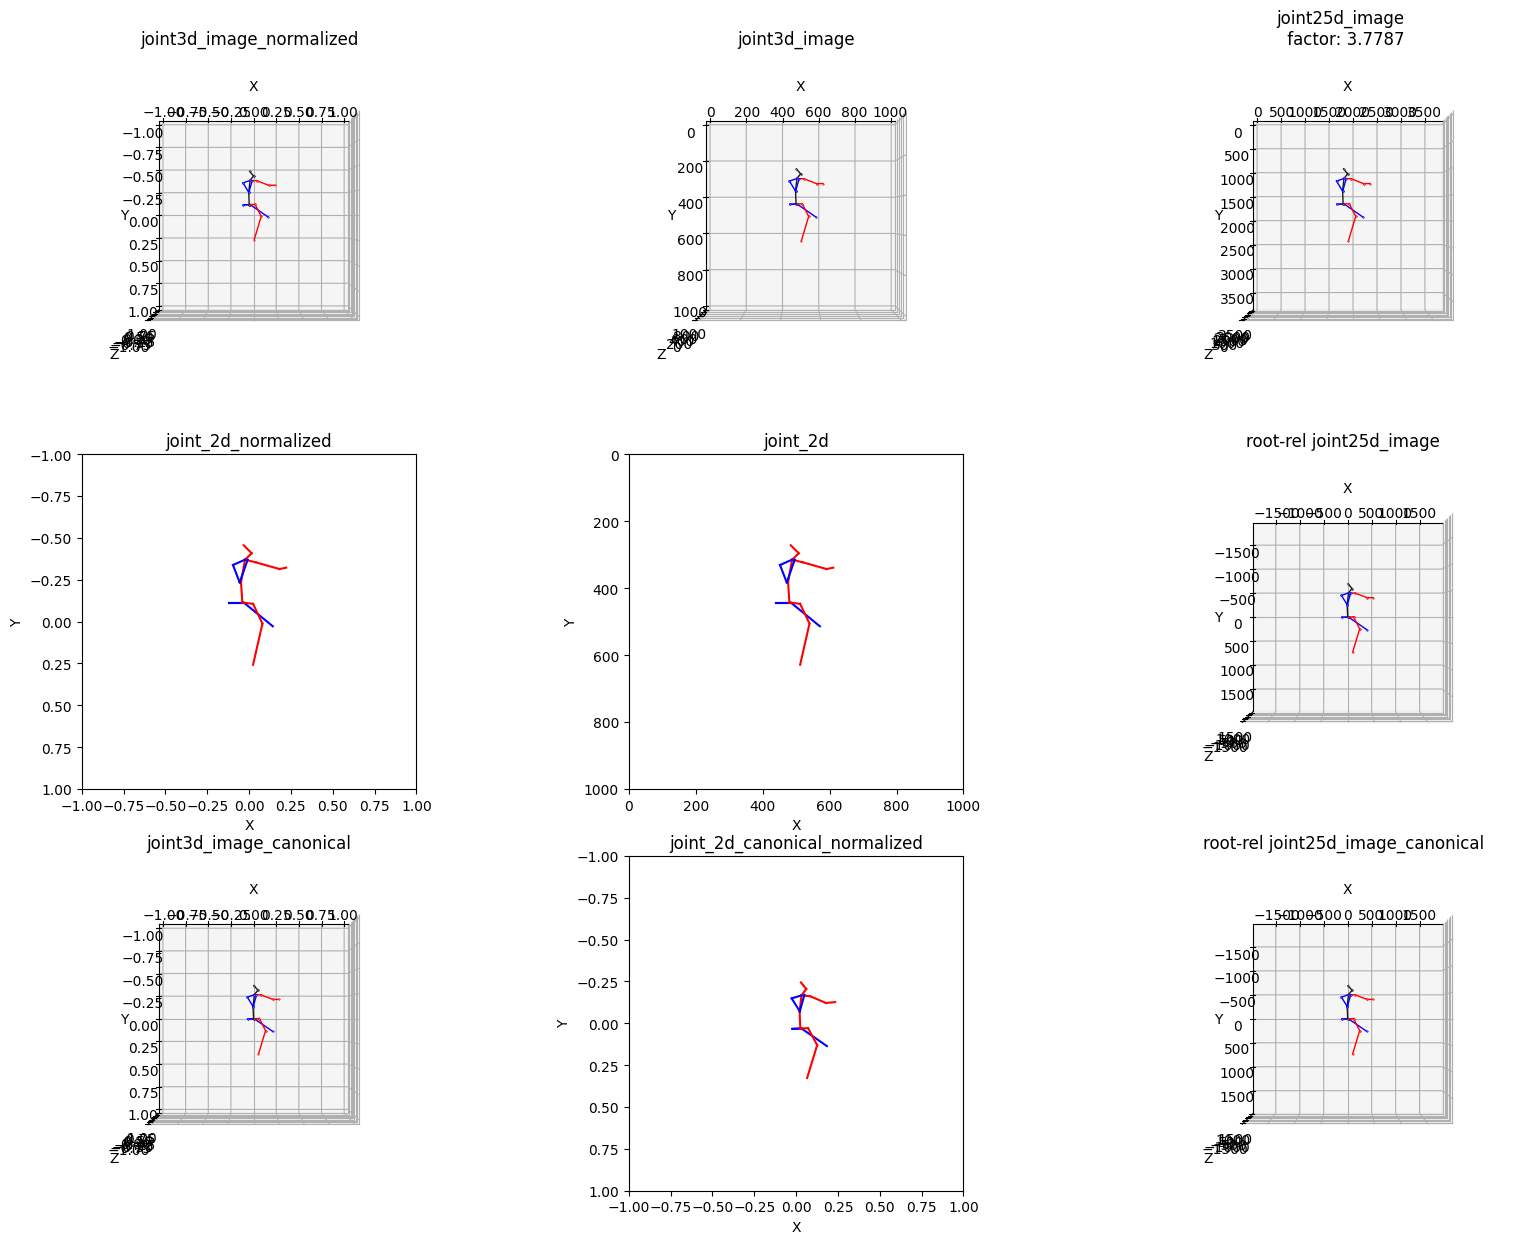

In [13]:
idx = 123004
print(h36m_pkl['test']['camera_name'][idx], h36m_pkl['test']['source'][idx])

l = list((np.where(np.array(h36m_pkl['test']['source']) == h36m_pkl['test']['source'][idx]))[0])
print(summarize_number_list(l))

%matplotlib inline
fig = plt.figure(1, figsize=(20, 20))
fig.clear()

def draw_example(pkl, idx, fig):

    joint_2d = h36m_pkl['test']['joint_2d'][idx]
    joint_3d_img = h36m_pkl['test']['joint3d_image'][idx]

    joint_3d_img_norm = normalize_3d_pose(joint_3d_img.copy())
    joint_2d_norm = normalize_2d_pose(joint_2d.copy())

    joint_25d_img = h36m_pkl['test']['joints_2.5d_image'][idx]
    factor = h36m_pkl['test']['2.5d_factor'][idx]

    joint_25d_img_root_rel = joint_25d_img.copy()
    joint_25d_img_root_rel -= joint_25d_img_root_rel[0]

    joint_3d_img_canonical = convert_to_canonical_space(joint_3d_img.copy(), np.array([500, 500, 0]), camera.cam_proj, rotate_to_camera_space=False)
    joint_3d_img_canonical_norm = normalize_3d_pose(joint_3d_img_canonical.copy())
    joint_3d_img_canonical_proj = projection(joint_3d_img_canonical_norm.copy(), camera.cam_proj)
    joint_3d_img_canonical_proj_norm = normalize_3d_pose(joint_3d_img_canonical_proj.copy())
    joint_25d_img_canonical = joint_3d_img_canonical.copy()*factor
    joint_25d_img_canonical_root_rel = joint_25d_img_canonical.copy() - joint_25d_img_canonical[0]



    ax1 = axes_3d(fig, loc=431, xlim=(-1,1), ylim=(-1,1),zlim=(-1,1), view=(-90, -90))
    ax1.set_title('joint3d_image_normalized')
    draw_3d_pose(ax1, joint_3d_img_norm)

    ax2 = axes_3d(fig, loc=432, xlim=(0,1000), ylim=(0,1000),zlim=(0,1000), view=(-90, -90))
    ax2.set_title('joint3d_image')
    draw_3d_pose(ax2, joint_3d_img)

    ax3 = axes_3d(fig, loc=433, xlim=(0,1000*factor), ylim=(0,1000*factor), zlim=(0,1000*factor), view=(-90, -90))
    ax3.set_title(f'joint25d_image \n factor: {factor:.4f}')
    draw_3d_pose(ax3, joint_25d_img)

    ax4 = axes_2d(fig, loc=434, normalize=True)
    ax4.set_title('joint_2d_normalized')
    draw_2d_pose(ax4, joint_2d_norm, normalize=True)

    ax5 = axes_2d(fig, loc=435, W=1000, H=1000)
    ax5.set_title('joint_2d')
    draw_2d_pose(ax5, joint_2d, normalize=False)

    ax6 = axes_3d(fig, loc=436, xlim=(-500*factor,500*factor), ylim=(-500*factor,500*factor), zlim=(-500*factor,500*factor), view=(-90, -90))
    ax6.set_title(f'root-rel joint25d_image')
    draw_3d_pose(ax6, joint_25d_img_root_rel)

    ax7 = axes_3d(fig, loc=437, xlim=(-1,1), ylim=(-1,1),zlim=(-1,1), view=(-90, -90))
    ax7.set_title('joint3d_image_canonical')
    draw_3d_pose(ax7, joint_3d_img_canonical_norm)

    ax8 = axes_2d(fig, loc=438, normalize=True)
    ax8.set_title('joint_2d_canonical_normalized')
    draw_2d_pose(ax8, joint_3d_img_canonical_proj_norm, normalize=True)

    ax9 = axes_3d(fig, loc=439, xlim=(-500*factor,500*factor), ylim=(-500*factor,500*factor), zlim=(-500*factor,500*factor), view=(-90, -90))
    ax9.set_title(f'root-rel joint25d_image_canonical')
    #draw_3d_pose(ax9, joint_25d_img_root_rel)
    draw_3d_pose(ax9, joint_25d_img_canonical_root_rel)

draw_example(h36m_pkl, idx, fig)
plt.show()

100%|██████████| 3820/3820 [14:14<00:00,  4.47it/s]


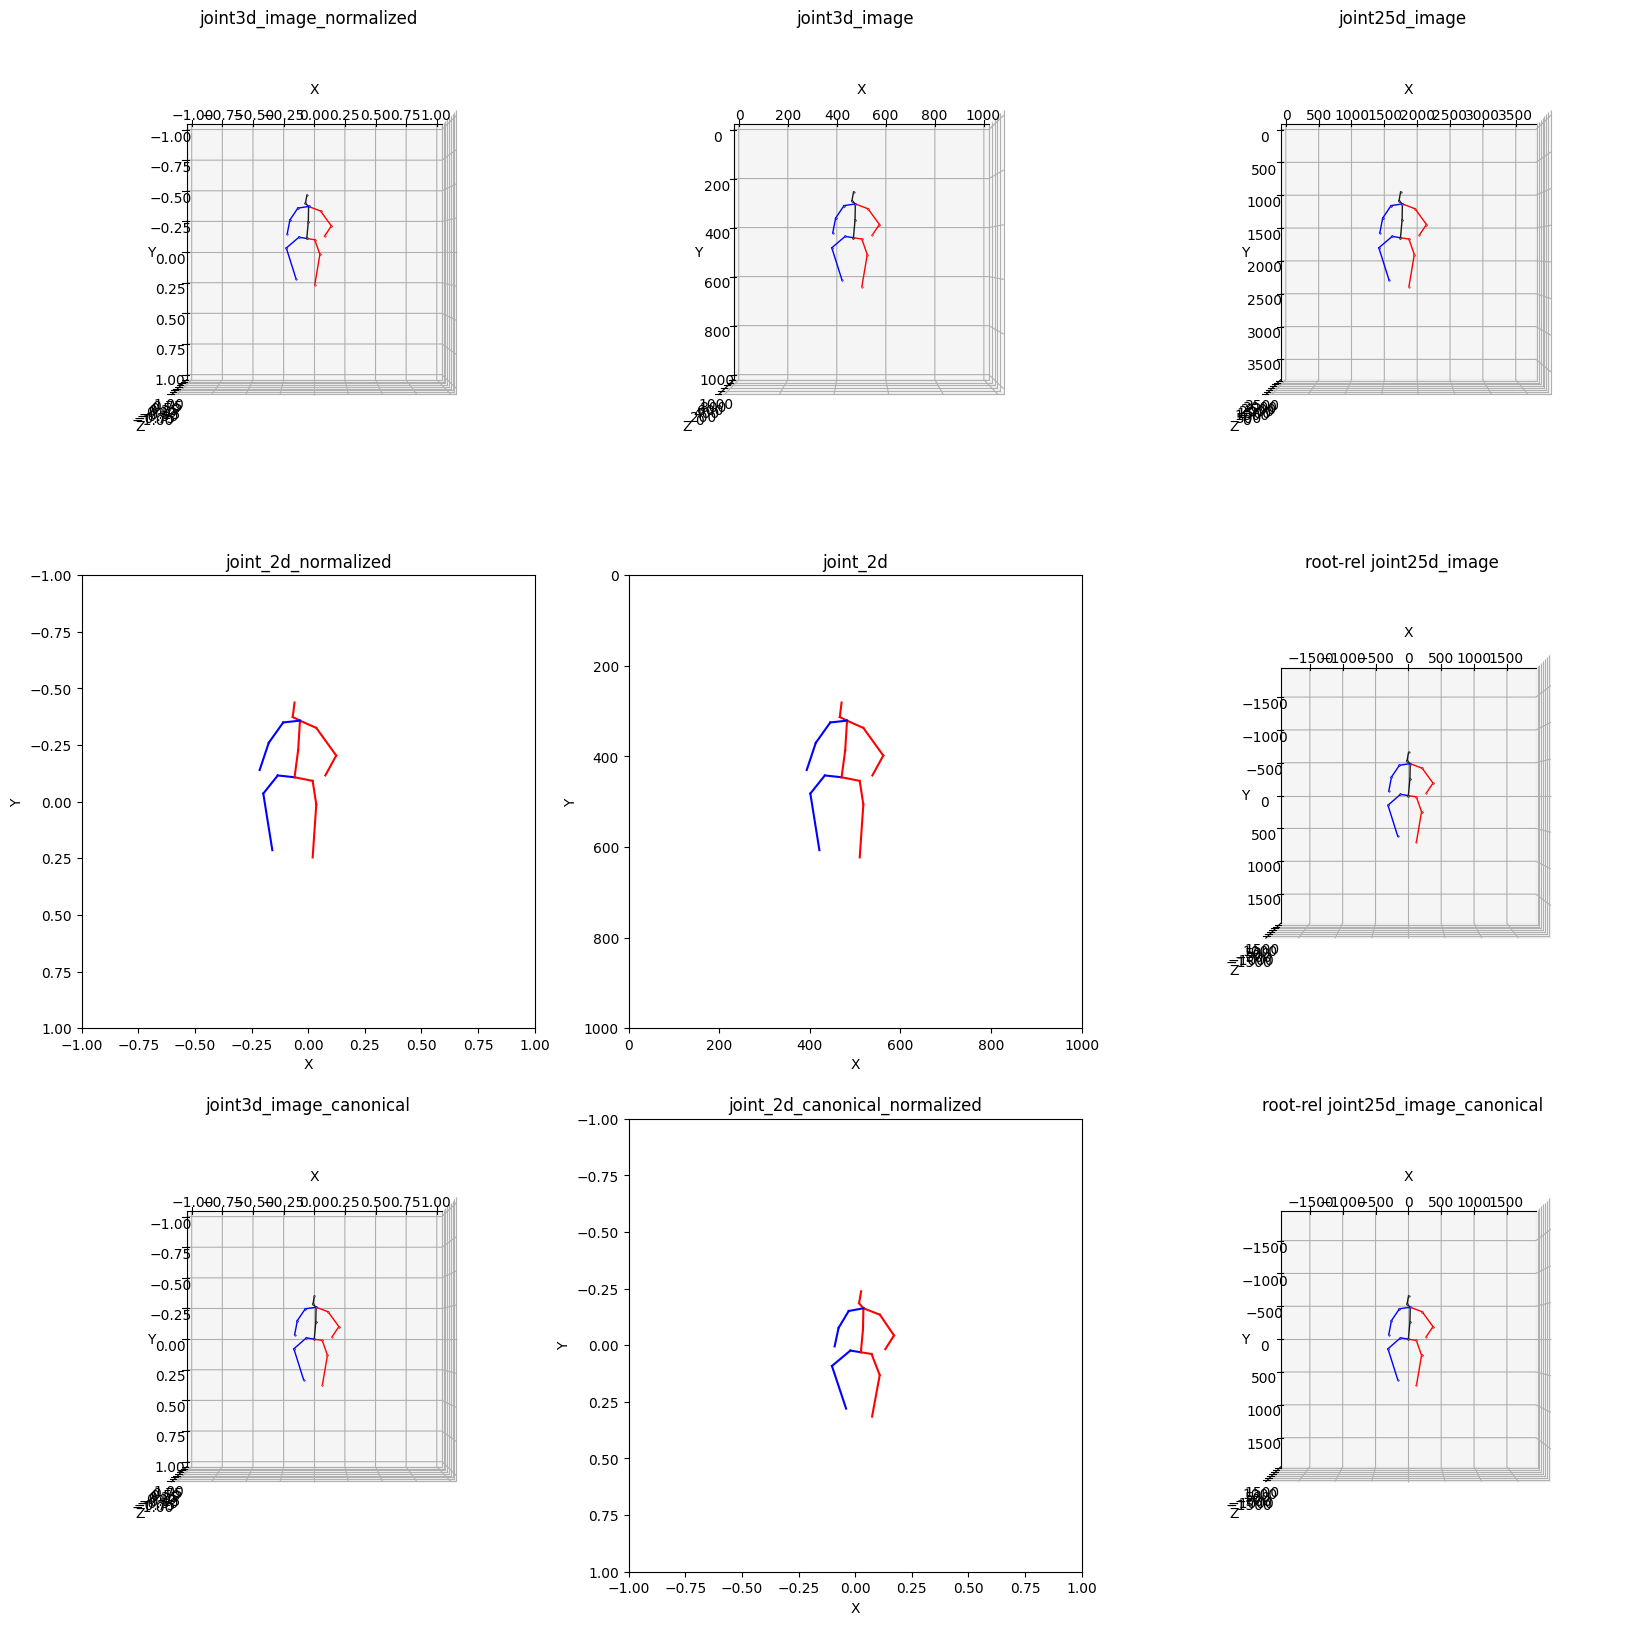

In [19]:
fig = plt.figure(2, figsize=(20, 20))
axd = fig.subplot_mosaic(
    """
    123
    456
    789
    """,
    per_subplot_kw={('1', '2', '3', '6', '7', '9'): {'projection': '3d'}}
)

ax1 = axes_3d(ax=axd['1'], xlim=(-1,1), ylim=(-1,1),zlim=(-1,1), view=(-90, -90))
ax1.set_title('joint3d_image_normalized')
ax2 = axes_3d(ax=axd['2'], xlim=(0,1000), ylim=(0,1000),zlim=(0,1000), view=(-90, -90))
ax2.set_title('joint3d_image')
ax3 = axes_3d(ax=axd['3'], view=(-90, -90))
ax3.set_title(f'joint25d_image')
ax4 = axes_2d(ax=axd['4'], normalize=True)
ax4.set_title('joint_2d_normalized')
ax5 = axes_2d(ax=axd['5'], W=1000, H=1000)
ax5.set_title('joint_2d')
ax6 = axes_3d(ax=axd['6'], view=(-90, -90))
ax6.set_title(f'root-rel joint25d_image')
ax7 = axes_3d(ax=axd['7'], xlim=(-1,1), ylim=(-1,1),zlim=(-1,1), view=(-90, -90))
ax7.set_title('joint3d_image_canonical')
ax8 = axes_2d(ax=axd['8'], normalize=True)
ax8.set_title('joint_2d_canonical_normalized')
ax9 = axes_3d(ax=axd['9'], view=(-90, -90))
ax9.set_title(f'root-rel joint25d_image_canonical')


videowriter = imageio.get_writer('s_09_act_06_subact_01_ca_01.mp4', fps=30)
start = 119483
end = 123303
for idx in tqdm(range(start, end)):
    joint_2d = h36m_pkl['test']['joint_2d'][idx]
    joint_3d_img = h36m_pkl['test']['joint3d_image'][idx]

    joint_3d_img_norm = normalize_3d_pose(joint_3d_img.copy())
    joint_2d_norm = normalize_2d_pose(joint_2d.copy())

    joint_25d_img = h36m_pkl['test']['joints_2.5d_image'][idx]
    factor = h36m_pkl['test']['2.5d_factor'][idx]

    joint_25d_img_root_rel = joint_25d_img.copy()
    joint_25d_img_root_rel -= joint_25d_img_root_rel[0]

    joint_3d_img_canonical = convert_to_canonical_space(joint_3d_img.copy(), np.array([500, 500, 0]), camera.cam_proj, rotate_to_camera_space=False)
    joint_3d_img_canonical_norm = normalize_3d_pose(joint_3d_img_canonical.copy())
    joint_3d_img_canonical_proj = projection(joint_3d_img_canonical_norm, camera.cam_proj)
    joint_3d_img_canonical_proj_norm = normalize_3d_pose(joint_3d_img_canonical_proj.copy())
    joint_25d_img_canonical = joint_3d_img_canonical.copy()*factor
    joint_25d_img_canonical_root_rel = joint_25d_img_canonical.copy() - joint_25d_img_canonical[0]

    clear_axes(ax1)
    clear_axes(ax2)
    clear_axes(ax3)
    clear_axes(ax4)
    clear_axes(ax5)
    clear_axes(ax6)
    clear_axes(ax7)
    clear_axes(ax8)
    clear_axes(ax9)

    ax3.set_xlim(0,1000*factor)
    ax3.set_ylim(0,1000*factor)
    ax3.set_zlim(0,1000*factor)
    ax6.set_xlim(-500*factor,500*factor)
    ax6.set_ylim(-500*factor,500*factor)
    ax6.set_zlim(-500*factor,500*factor)
    ax9.set_xlim(-500*factor,500*factor)
    ax9.set_ylim(-500*factor,500*factor)
    ax9.set_zlim(-500*factor,500*factor)
    
    draw_3d_pose(ax1, joint_3d_img_norm)
    draw_3d_pose(ax2, joint_3d_img)
    draw_3d_pose(ax3, joint_25d_img)
    draw_2d_pose(ax4, joint_2d_norm, normalize=True)
    draw_2d_pose(ax5, joint_2d, normalize=False)
    draw_3d_pose(ax6, joint_25d_img_root_rel)
    draw_3d_pose(ax7, joint_3d_img_canonical_norm)
    draw_2d_pose(ax8, joint_3d_img_canonical_proj_norm, normalize=True)
    draw_3d_pose(ax9, joint_25d_img_canonical_root_rel)
    

    #draw_example(h36m_pkl, idx, fig)

    canvas = FigureCanvas(fig)
    canvas.draw()
    image_from_plot = np.array(canvas.renderer._renderer)
    image_from_plot = cv2.cvtColor(image_from_plot, cv2.COLOR_RGB2BGR)

    videowriter.append_data(image_from_plot)
videowriter.close()

### Generate S1 train S5,6,7,8 test pkl 

In [19]:
subject_list = []
for source in h36m_pkl['train']['source']:
    subject = source.split('_')[1]
    subject_list.append(subject)
set(subject_list)

{'01', '05', '06', '07', '08'}

In [20]:
subject_list = []
for source in h36m_pkl['test']['source']:
    subject = source.split('_')[1]
    subject_list.append(subject)
set(subject_list)

{'09', '11'}

In [21]:
new_pkl_path = '/home/hrai/codes/MotionBERT/data/motion3d/h36m_sh_conf_cam_source_final_with_canonical.pkl'
new_h36m_pkl = {'train': {}, 'test': {}} # h36m_pkl.copy()

In [33]:
# S01
S01_idx = []
S05_idx = []
S06_idx = []
S07_idx = []
S08_idx = []
for i, source in enumerate(h36m_pkl['train']['source']):
    if 's_01' in source:
        S01_idx.append(i)
    elif 's_05' in source:
        S05_idx.append(i)
    elif 's_06' in source:
        S06_idx.append(i)
    elif 's_07' in source:
        S07_idx.append(i)
    elif 's_08' in source:
        S08_idx.append(i)

train_idx = S01_idx
test_idx = S05_idx + S06_idx + S07_idx + S08_idx

In [26]:
len(S01_idx), len(S05_idx), len(S06_idx), len(S07_idx), len(S08_idx)

(248376, 396316, 249864, 406484, 258712)

In [37]:
h36m_pkl['train'].keys(), h36m_pkl['test'].keys()

(dict_keys(['joint_2d', 'confidence', 'joint3d_image', 'camera_name', 'source']),
 dict_keys(['joint_2d', 'confidence', 'joint3d_image', 'joints_2.5d_image', '2.5d_factor', 'camera_name', 'action', 'source']))

In [45]:
action_num_list = []
for i, source in enumerate(h36m_pkl['test']['source']):
    action = source.split('_')[3]
    #print(action)
    if action not in action_num_list:
        action_num_list.append(action)
        print(action, h36m_pkl['test']['action'][i])
    #break

02 Direction
03 Discuss
04 Eating
05 Greet
06 Phone
07 Pose
08 Purchase
09 Sitting
10 SittingDown
11 Smoke
12 Photo
13 Wait
14 Walk
15 WalkDog
16 WalkTwo


In [46]:
action_mapping = {
    '02': 'Direction',
    '03': 'Discuss',
    '04': 'Eating',
    '05': 'Greet',
    '06': 'Phone',
    '07': 'Pose',
    '08': 'Purchase',
    '09': 'Sitting',
    '10': 'SittingDown',
    '11': 'Smoke',
    '12': 'Photo',
    '13': 'Wait',
    '14': 'Walk',
    '15': 'WalkDog',
    '16': 'WalkTwo'
}

### Convert to canonical input space

In [48]:
for key in h36m_pkl['train'].keys():
    new_h36m_pkl['train'][key] = np.array(h36m_pkl['train'][key])[train_idx].copy()
    print(key, np.array(new_h36m_pkl['train'][key]).shape)

for key in h36m_pkl['train'].keys():
    new_h36m_pkl['test'][key] = np.array(h36m_pkl['train'][key])[test_idx].copy()
    print(key, np.array(new_h36m_pkl['test'][key]).shape)

new_h36m_pkl['test']['action'] = []
for i, source in enumerate(h36m_pkl['test']['source']):
    action = source.split('_')[3]
    new_h36m_pkl['test']['action'].append(action_mapping[action])

joint_2d (248376, 17, 2)
confidence (248376, 17, 1)
joint3d_image (248376, 17, 3)
camera_name (248376,)
source (248376,)
joint_2d (1311376, 17, 2)
confidence (1311376, 17, 1)
joint3d_image (1311376, 17, 3)
camera_name (1311376,)
source (1311376,)


In [119]:
new_h36m_pkl['train']['joint3d_image'] = new_h36m_pkl['train']['joint3d_image'] - new_h36m_pkl['train']['joint3d_image'][:, 0:1, :]
new_h36m_pkl['test']['joint3d_image'] = new_h36m_pkl['test']['joint3d_image'] - new_h36m_pkl['test']['joint3d_image'][:, 0:1, :]d

In [118]:
for i in tqdm(range(len(new_h36m_pkl['train']['joint3d_image']))):
    joint_3d_img_canonical = new_h36m_pkl['train']['joint3d_image'][i]
    #joint_3d_img_canonical = convert_to_canonical_space(joint_3d_img, False)
    joint_3d_img_proj = projection(joint_3d_img_canonical, camera.cam_proj)
    #new_h36m_pkl['train']['joint3d_image'][i] = joint_3d_img_canonical
    new_h36m_pkl['train']['joint_2d'][i] = joint_3d_img_proj[:, :2]
    #break

  0%|          | 0/1559752 [00:00<?, ?it/s]

  8%|▊         | 125411/1559752 [00:01<00:14, 97567.37it/s]/home/hrai/codes/hpe_library/my_utils/dh.py:41: RuntimeWarning: divide by zero encountered in divide
  pose_2d = projected / projected[:, 2].repeat(3).reshape(-1, 3)
/home/hrai/codes/hpe_library/my_utils/dh.py:41: RuntimeWarning: invalid value encountered in divide
  pose_2d = projected / projected[:, 2].repeat(3).reshape(-1, 3)
100%|██████████| 1559752/1559752 [00:15<00:00, 97581.42it/s]


In [120]:
for i in tqdm(range(len(new_h36m_pkl['test']['joint3d_image']))):
    joint_3d_img_canonical = new_h36m_pkl['test']['joint3d_image'][i]
    joint_3d_img_proj = projection(joint_3d_img_canonical, camera.cam_proj)
    new_h36m_pkl['test']['joint_2d'][i] = joint_3d_img_proj[:, :2]
    #break

100%|██████████| 566920/566920 [00:05<00:00, 95536.84it/s]


60457274 s_09_act_11_subact_01_ca_01
['210916-215292']


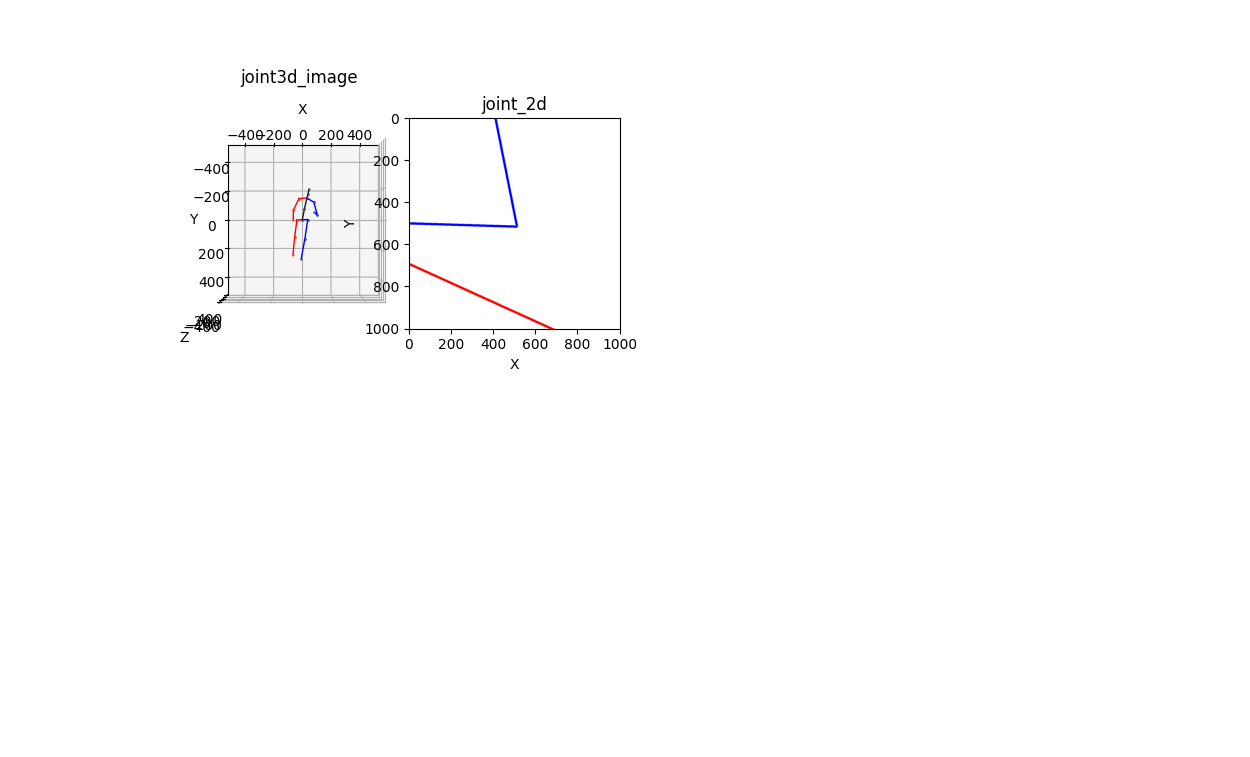

In [126]:
idx = 212059 -200
print(new_h36m_pkl['test']['camera_name'][idx], new_h36m_pkl['test']['source'][idx])

l = list((np.where(np.array(new_h36m_pkl['test']['source']) == new_h36m_pkl['test']['source'][idx]))[0])
print(summarize_number_list(l))

joint_2d = new_h36m_pkl['test']['joint_2d'][idx]
joint_3d_img = new_h36m_pkl['test']['joint3d_image'][idx]

joint_3d_img_norm = normalize_3d_pose(joint_3d_img.copy())
joint_2d_norm = normalize_2d_pose(joint_2d.copy())



%matplotlib widget
fig = plt.figure(2, figsize=(15, 5))
fig.clear()

ax1 = axes_3d(fig, loc=231, xlim=(-500,500), ylim=(-500,500),zlim=(-500,500), view=(-90, -90))
ax1.set_title('joint3d_image')
draw_3d_pose(ax1, joint_3d_img)

ax2 = axes_2d(fig, loc=242, W=1000, H=1000)
ax2.set_title('joint_2d')
draw_2d_pose(ax2, joint_2d, normalize=False)


plt.show()

###

In [104]:
os.chdir(motionbert_root)
from lib.utils.tools import * # get_config
from lib.utils.learning import * # load_backbone
from lib.model.loss import *
from lib.data.datareader_kookmin import DataReaderKOOKMIN
from lib.data.datareader_h36m import DataReaderH36M
from lib.data.datareader_random_limb import DataReaderRandomLimb
from lib.data.dataset_motion_3d import MotionDataset3D
from lib.model.DHDSTformer import DHDSTformer, DHDSTformer2, DHDSTformer3, DHDSTformer_limb, DHDSTformer_torso

def parse_args(target):
    parser = argparse.ArgumentParser()
    parser.add_argument("--config", type=str, default="configs/pose3d/DHDST_kookmin_baseline.yaml", help="Path to the config file.")
    parser.add_argument('-c', '--checkpoint', default='checkpoint', type=str, metavar='PATH', help='checkpoint directory')
    parser.add_argument('-p', '--pretrained', default='checkpoint', type=str, metavar='PATH', help='pretrained checkpoint directory')
    parser.add_argument('-r', '--resume', default='', type=str, metavar='FILENAME', help='checkpoint to resume (file name)')
    parser.add_argument('-e', '--evaluate', default='checkpoint/pose3d/MB_ft_h36m/best_epoch.bin', type=str, metavar='FILENAME', help='checkpoint to evaluate (file name)')
    parser.add_argument('-ms', '--selection', default='best_epoch.bin', type=str, metavar='FILENAME', help='checkpoint to finetune (file name)')
    parser.add_argument('-sd', '--seed', default=0, type=int, help='random seed')
    parser.add_argument('-g', '--gpu', default='0', type=str, help='GPU id')
    #opts = parser.parse_args([])
    opts = parser.parse_args([
        '--config', 'configs/pose3d/{}.yaml'.format(target),
        '--evaluate', 'checkpoint/pose3d/{}/best_epoch.bin'.format(target)])
    return opts

target = 'MB_ft_h36m'
opts = parse_args(target=target)
args = get_config(opts.config)
print(opts.evaluate)

checkpoint/pose3d/MB_ft_h36m/best_epoch.bin


In [105]:
args.dt_file = 'h36m_sh_conf_cam_source_final.pkl'
args.subset_list = ['H36M-SH']
datareader = DataReaderH36M(n_frames=args.clip_len, sample_stride=args.sample_stride, data_stride_train=args.data_stride, data_stride_test=args.clip_len, dt_root = 'data/motion3d', dt_file=args.dt_file)
testloader_params = {
        'batch_size': args.batch_size,
        'shuffle': False,
        'num_workers': 12,
        'pin_memory': True,
        'prefetch_factor': 4,
        'persistent_workers': True
}
test_dataset = MotionDataset3D(args, args.subset_list, 'test')
test_loader = DataLoader(test_dataset, **testloader_params)


In [106]:
loss = 0
with torch.no_grad():
    for batch_input, batch_gt in tqdm(test_loader):
        if torch.cuda.is_available():
            batch_input = batch_input.cuda()
            batch_gt = batch_gt.cuda()
        break


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:03<?, ?it/s]


In [107]:
batch_input.shape, batch_gt.shape

(torch.Size([16, 243, 17, 3]), torch.Size([16, 243, 17, 3]))